In [1]:
import warnings
import time
warnings.filterwarnings('ignore')
#import tensorflow as tf # This may laod Tensorflow 2.0.0 if that is the verison of the package on your distribution
import tensorflow.compat.v1 as tf #for tensorflow 1
print(tf.__version__)
tf.disable_v2_behavior() # Only needed if using tensorflow 1 with tensorflow 2 being the package avlaiable  
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from sklearn import preprocessing
from sklearn.decomposition import PCA
%matplotlib inline

2.1.0
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Loading all again to ensure proper shape of x_train: need [28,28] not [28*28]

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data() #Load mnist
n_train = x_train.shape[0]
n_test = x_test.shape[0]
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1 #Translate pixel values to range [-1,1]

x_vali, x_test = x_test[:int(0.2*n_test)], x_test[int(0.2*n_test):]  #Create set for validation also

print(x_train.shape, x_vali.shape, x_test.shape)

(60000, 28, 28) (2000, 28, 28) (8000, 28, 28)


In [3]:
#Denoising AutoEncoder Class

class DAE:
    def __init__(self, x_train, output_dir, lr=0.001, nb_epochs=1, batch_size=128):
        #Set up shop
        
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        
        self.im = tf.placeholder(tf.float32, [None, 28, 28,1]) #Placeholder for network input
        self.im_clean = tf.placeholder(tf.float32, [None, 28, 28,1]) #Placeholder for clean image (as opposed to noisy)
        #Note that we could've used placeholder with default instead
        
        self.x_train = x_train
        
        
    def create_model(self):
        with tf.variable_scope('DAE', reuse=tf.AUTO_REUSE):
            
            #Encoder
            #Use padding='same' to ensure output dimension is [28,28] for images
            conv1 = tf.layers.conv2d(inputs=self.im, filters=32,padding="same", strides=1, kernel_size=4, activation=tf.nn.relu)
            conv2 = tf.layers.conv2d(inputs=conv1, filters=64,padding="same", strides=2, kernel_size=4, activation=tf.nn.relu)
            conv3 = tf.layers.conv2d(inputs=conv2, filters=128,padding="same", strides=2, kernel_size=4, activation=tf.nn.relu)
            
            #Decoder
            deconv1 = tf.layers.conv2d_transpose(inputs=conv3,padding="same",strides=2, filters=64, kernel_size=4, activation=tf.nn.relu)
            deconv2 = tf.layers.conv2d_transpose(inputs=deconv1,padding="same",strides=2, filters=32, kernel_size=4, activation=tf.nn.relu)
            self.recon_im = tf.layers.conv2d(inputs=deconv2,padding="same", filters=1, strides=1, kernel_size=4, activation=tf.math.tanh)
            #Note, we use tanh for output as range needed is [-1,1]
            
            tf.summary.image('denoising', tf.concat([self.im, self.recon_im], axis=2))
                             
    def compute_loss(self):
        with tf.variable_scope('loss'):
            
            #Loss function: mean squared error between DAE output and noiseless images
            self.loss = tf.losses.mean_squared_error(self.im_clean, self.recon_im)
            
            self.loss_summ = tf.summary.scalar("reconstruction_loss", self.loss)
                             
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [4]:

#Create model, train with 1 epoch and batch size of 128
model = DAE(x_train, './DAE_logdir/')
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


In [5]:
#Seems that around noise_std=0.8 is the point at which the autoencoder fails to train consistently
noise_std = 0.4 #standard deviation of noise

startT = time.time()

losses = []
losses_vali = []

#Number of noisy images per training input image during iteration
noises_per_im = 4


x_vali_in = np.expand_dims(x_vali, axis=-1) #Make correct shape [?,28,28,1]
x_vali_in_n = x_vali_in + np.random.normal(scale= noise_std, size=x_vali_in.shape)

#Train
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    x_in = np.expand_dims(x_in, axis=-1) # Make correct shape [?,28,28,1]
    
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        
        #Run multiple times for same image batch to simulate multiple noisy images per clean image
        for run in range(noises_per_im):
            input_x_train_n = input_x_train + np.random.normal(scale= noise_std, size=input_x_train.shape) #inject noise
            
            _ , loss, loss_summ = sess.run([model.trainer, model.loss, model.loss_summ], #run training for a batch
                                     feed_dict={model.im: input_x_train_n, model.im_clean: input_x_train} )
            
        #Record training losses per iteration
        losses.append(loss)
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        
        #Record validation losses per iteration
        loss_vali = sess.run(model.loss, feed_dict={model.im: x_vali_in_n, model.im_clean: x_vali_in})
        losses_vali.append(loss_vali)
        
        
    saver.save(sess, model.output_dir, global_step=epoch)  

#Record time
timeTaken = int(time.time() - startT)
print(timeTaken,'s taken')

60 s taken


In [6]:
#Obtain average loss on test set using different noise each time over 20 sets

loss_tests = 0

#Record test losses averaged over 20 noised images after training
for test_num in range(20):
    x_test_in = np.expand_dims(x_test, axis=-1)
    x_test_in_n = x_test_in + np.random.normal(scale= noise_std, size=x_test_in.shape)
    loss_test= sess.run(model.loss, 
                        feed_dict={model.im: x_test_in_n, model.im_clean: x_test_in})
    loss_tests += loss_test

#Average test losses
loss_tests /= 20

0.010423205886036157 so average pixel error is 0.10209410309139386


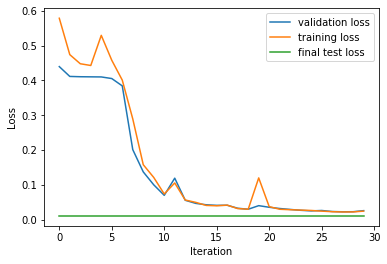

In [7]:
#Plot results of training/testing for first 30 iterations

print(loss_tests, 'so average pixel error is', np.sqrt(loss_tests))
plt.plot(losses_vali[:30], label='validation loss')
plt.plot(losses[:30], label='training loss')
plt.plot(np.arange(30), 30*[loss_tests], label='final test loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

0.010423205886036157 so average pixel error is 0.10209410309139386


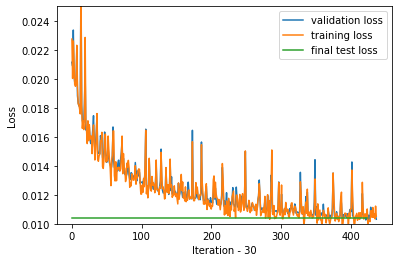

In [8]:
#Plot results of training/testing after first 30 iterations

print(loss_tests, 'so average pixel error is', np.sqrt(loss_tests))
plt.plot(losses_vali[30:], label='validation loss')
plt.plot(losses[30:], label='training loss')
plt.plot(np.arange(425), 425*[loss_tests], label='final test loss')
plt.ylim(0.01,0.025)
plt.xlabel("Iteration - 30")
plt.ylabel("Loss")
plt.legend()

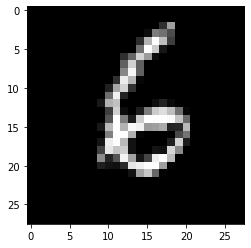

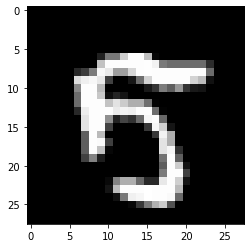

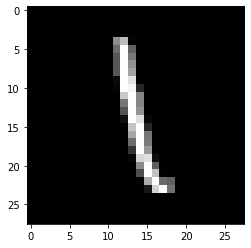

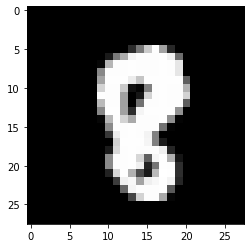

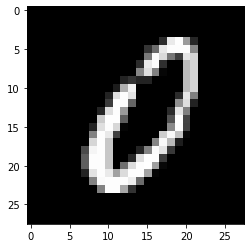

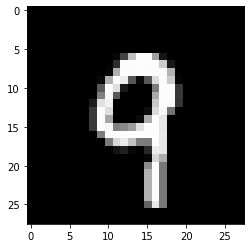

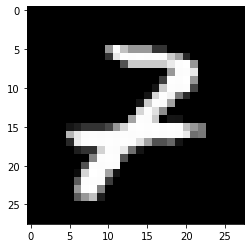

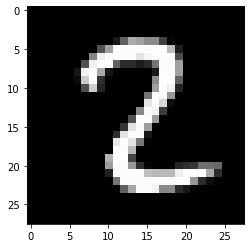

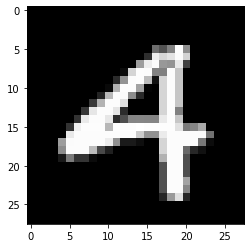

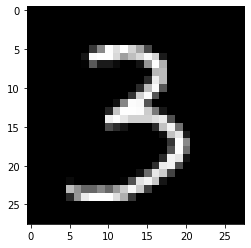

In [9]:
#Plot some test images

test_egs = x_test

plt.imshow(test_egs[0], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[1], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[10], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[50], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[67], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[14], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[16], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[85], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[900], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[32], interpolation='nearest', cmap='gray')
plt.show()

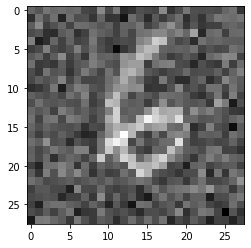

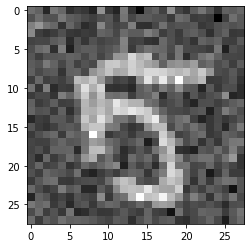

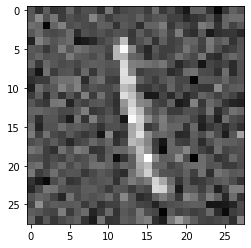

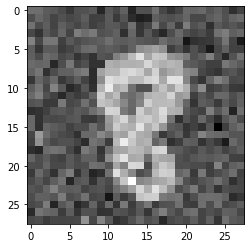

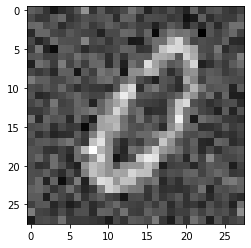

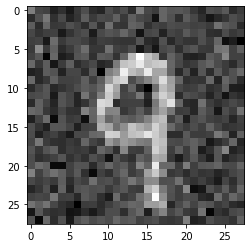

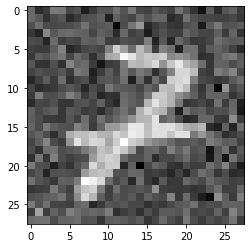

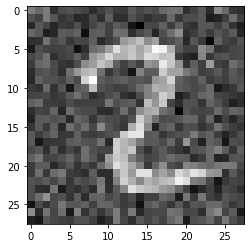

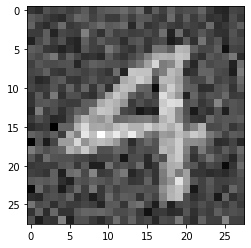

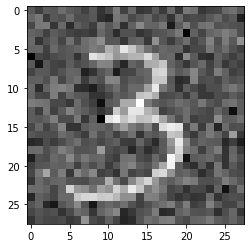

In [10]:
#Add some noise to those test images and plot

test_egs = x_test
test_noise = np.random.normal(scale= noise_std, size=test_egs.shape)
test_noise_exp = np.expand_dims(test_noise,axis=-1)
test_egs = test_egs + test_noise

plt.imshow(test_egs[0], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[1], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[10], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[50], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[67], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[14], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[16], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[85], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[900], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs[32], interpolation='nearest', cmap='gray')
plt.show()

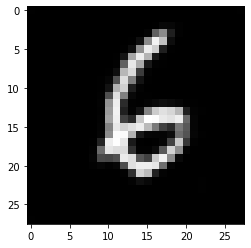

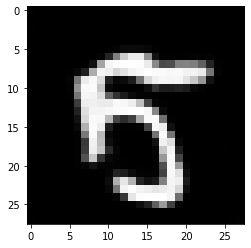

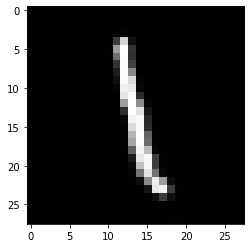

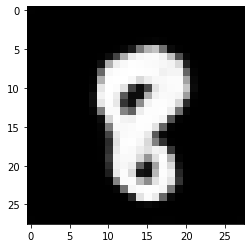

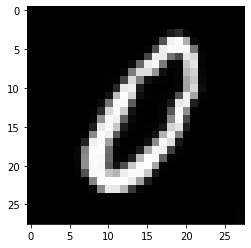

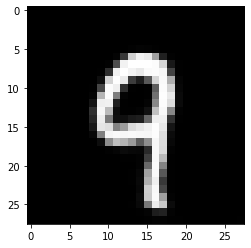

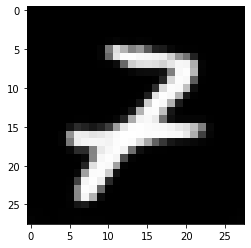

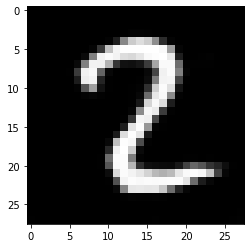

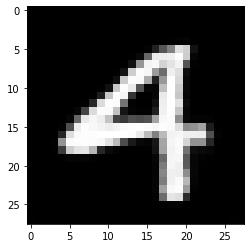

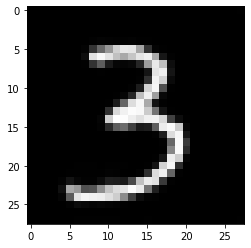

In [11]:
#Denoise those noisy test images and plot

test_egs_re = sess.run(model.recon_im, feed_dict={model.im: x_test_in+ test_noise_exp})
test_egs_re = np.squeeze(test_egs_re)

plt.imshow(test_egs_re[0], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[1], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[10], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[50], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[67], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[14], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[16], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[85], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[900], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(test_egs_re[32], interpolation='nearest', cmap='gray')
plt.show()

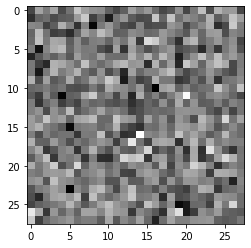

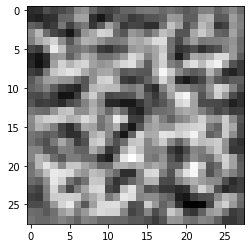

In [12]:
#Experiment1: Denoising pure noise and plot

noise_input = np.random.normal(scale=noise_std, size=(test_egs.shape[1],test_egs.shape[1]))
plt.imshow(noise_input, interpolation='nearest', cmap='gray')
plt.show()
noise_input = np.asarray([np.expand_dims(noise_input, axis=-1)])
noise_output = sess.run(model.recon_im, feed_dict={model.im: noise_input})
plt.imshow(np.squeeze(noise_output[0]), interpolation='nearest', cmap='gray')
plt.show()

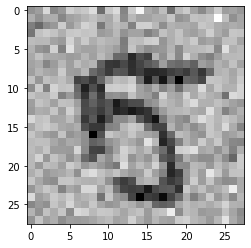

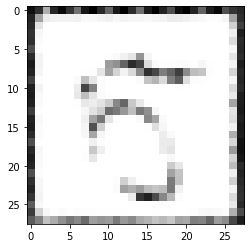

In [13]:
#Experiment2: Denoising inverted 5 and plot

irreg_input = np.ones((28,28))
irreg_input = irreg_input - test_egs[1]
plt.imshow(irreg_input, interpolation='nearest', cmap='gray')
plt.show()
irreg_input = np.asarray([np.expand_dims(irreg_input, axis=-1)])
irreg_output = sess.run(model.recon_im, feed_dict={model.im: irreg_input})
plt.imshow(np.squeeze(irreg_output[0]), interpolation='nearest', cmap='gray')
plt.show()

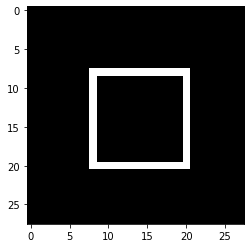

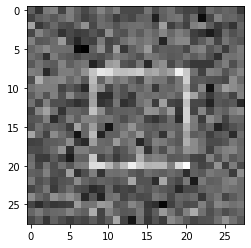

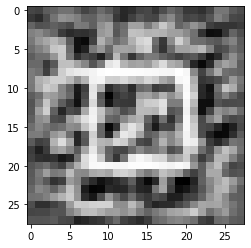

In [14]:
#Experiment3: Denoising noised box image and plot

box_input = np.zeros((28,28))
box_input[8,8:20] = 1
box_input[20,8:20] = 1
box_input[8:20,8] = 1
box_input[8:21,20] = 1

plt.imshow(box_input, interpolation='nearest', cmap='gray')
plt.show()

box_input = box_input + np.random.normal(scale= noise_std, size=(28,28))
plt.imshow(box_input, interpolation='nearest', cmap='gray')
plt.show()

box_input = np.asarray([np.expand_dims(box_input, axis=-1)])
box_output = sess.run(model.recon_im, feed_dict={model.im: box_input})
plt.imshow(np.squeeze(box_output[0]), interpolation='nearest', cmap='gray')
plt.show()